In [1]:
import torch
import scanpy as sc
import anndata as ad
import celldiffusion as cd


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda
NVIDIA L40S


In [3]:
REF_PATH = '/projectnb/czlab/A00/ycliu/scRNA_annotation_benchmark_datasets/PBMC7K_ref1/'

DATA_PATH = '/projectnb/czlab/A00/ycliu/scRNA_annotation_benchmark_datasets/PBMC7K/'

OUTPUT_PATH = 'outputs/'

# Load dataset

In [4]:
adata_ref = sc.read_h5ad(REF_PATH + 'PBMC7K_ref1.h5ad')
adata_query = sc.read_h5ad(DATA_PATH + 'PBMC7K.h5ad')

In [5]:
# 'ref_label' represents the reference cell identities. For Query Data, set as "NewData" 
adata_ref.obs['ref_label']=adata_ref.obs['labels']
adata_query.obs['ref_label']= 'NewData'

In [6]:
# 'batch' represent the reference and query labels.
adata_ref.obs['batch']= 'Reference'
adata_query.obs['batch']= 'New'

In [7]:
# Combine Reference and New Data
adata = ad.concat([adata_query, adata_ref], merge='same')

# Preprocess

/usr2/postdoc/ycliu137/.conda/envs/diffusion_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


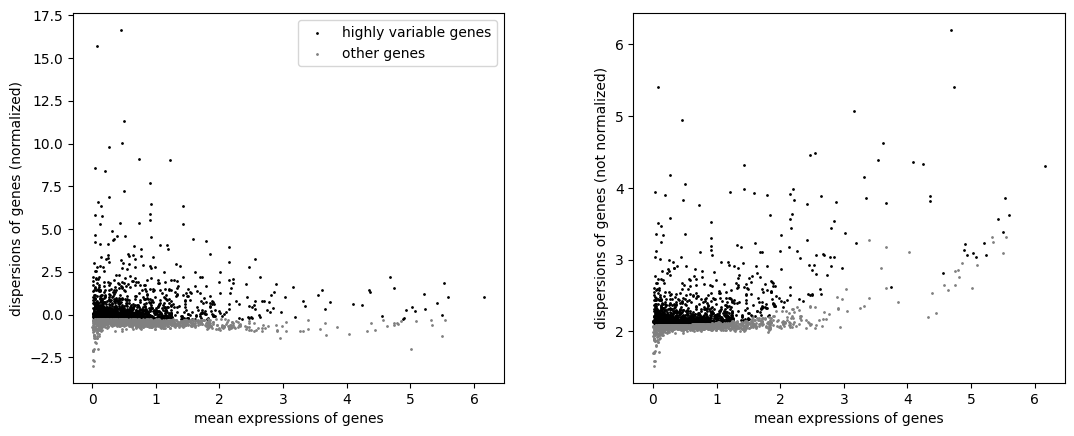

In [8]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [9]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# Feature encoder

In [10]:
cd.encode_features(adata, 
                D_encode_list=[2000, 300, 50], # Encoder dimension in each layer
                D_decode_list=[50, 300, 2000], # Decoder dimension in each layer
                max_epoch=2000,      # number of epoch
                lr=1e-3,             # learning rate
                device=device)


2025-07-21 15:53:27,269 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/Pan_proj/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2025-07-21 15:53:28,948 - ------------------------> Epoch: 1/2000, Current loss: 20402314.0000
2025-07-21 15:53:29,882 - ------------------------> Epoch: 51/2000, Current loss: 8597916.0000
2025-07-21 15:53:30,814 - ------------------------> Epoch: 101/2000, Current loss: 8273802.0000
2025-07-21 15:53:31,746 - ------------------------> Epoch: 151/2000, Current loss: 8053840.0000
2025-07-21 15:53:32,675 - ------------------------> Epoch: 201/2000, Current loss: 7881651.5000
2025-07-21 15:53:33,609 - ------------------------> Epoch: 251/2000, Current loss: 7764175.00

# Integrating query with reference

In [11]:
# Build the diffusion graph for data intagration

cd.inte.build_integration_graph(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            n_edges_per_node=50, # Number of outgoing edges of each node in the diffusion graph.
                            k_mnn=50,      # K for KNNs that toward finding MNNs.
                            device=device)

In [12]:
# Build the input KNN adjacencies for each batch, which is used in loss function.

cd.inte.build_integration_loss_adj(adata, 
                                   use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                                   k=50,            # K for building KNN graph
                                   device=device)

In [13]:
cd.inte.integration_diffusion(adata, 
                              use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                              max_epoch=2000,  # The number of training epoch
                              lr=1e-3,         # Learning rate
                              time_increment_diffusion=0.2, # Suggested value==0.2 when using 8 diffusion layers.
                              device=device)


2025-07-21 15:54:17,363 - --------> Starting data integration ...
/projectnb/czproj/Algorithms/ycliu/Pan_proj/sc_integration/integration_DIF.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_now = torch.tensor(adjacency_list[ii].to(device), dtype = recon_adj_list[ii].dtype)
2025-07-21 15:54:17,539 - ------------------------> Epoch: 1/2000, Current loss: 12308518912.0000
2025-07-21 15:54:24,138 - ------------------------> Epoch: 51/2000, Current loss: 83604184.0000
2025-07-21 15:54:30,742 - ------------------------> Epoch: 101/2000, Current loss: 62325284.0000
2025-07-21 15:54:37,346 - ------------------------> Epoch: 151/2000, Current loss: 59358304.0000
2025-07-21 15:54:43,944 - ------------------------> Epoch: 201/2000, Current loss: 58075776.0000
2025-07-21 15:54:50,542 - ------------------------> Epoch: 251/2000, Current 

## View integrated embeddings

In [14]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

/usr2/postdoc/ycliu137/.conda/envs/diffusion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


... storing 'batch' as categorical
... storing 'ref_label' as categorical


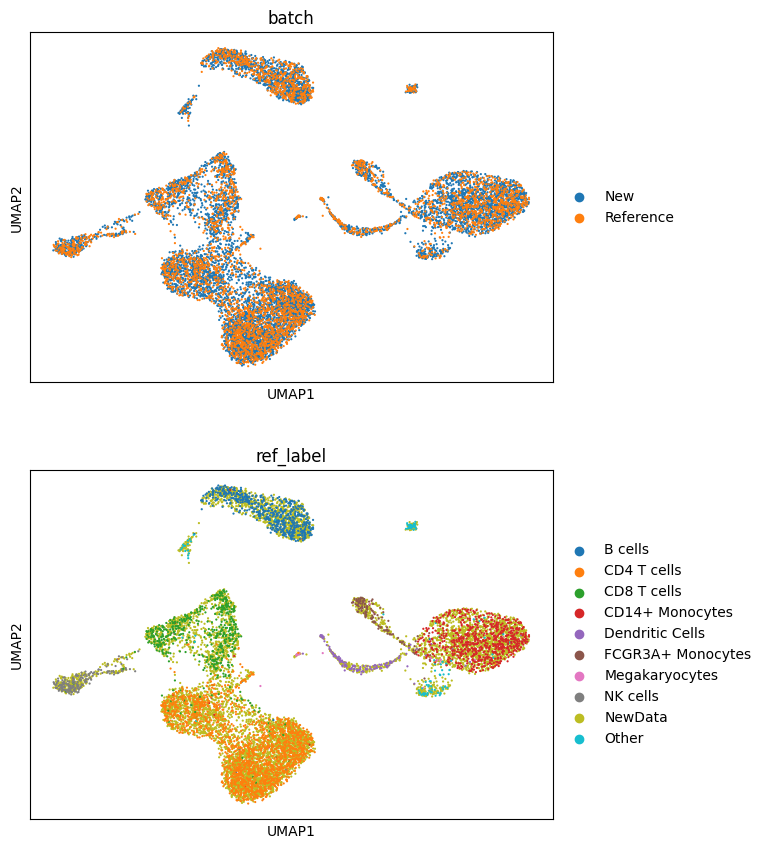

In [15]:
sc.pl.umap(adata, color=['batch', 'ref_label'],ncols=1)

# Annotation

In [16]:
cd.anal.transfer_annotation(adata,   # Anndata object that combines Reference and New Data 
           use_rep='X_fae',        # the embeddings used to build the label transfer graph
           use_label='ref_label',     # For Reference, it should be cell identities to be transfer; For New Data, could be labeled as "New".
           batch_key='batch',     # The key to distinguish Reference and New Data. 
           ref_batch='Reference',     # the batch label for Reference used in 'batch_key'
           data_batch='New',        # the batch label for New Data used in 'batch_key'
           n_edges_per_node=50,   # K-value in KNN graph or MNN graph
           use_mnn=False,       # if use MNN to build graph     
           device='cpu'    # 'cpu' or 'cuda'
                    )

... storing 'batch_labels' as categorical
... storing 'transfered_labels' as categorical
... storing 'reference_alignment' as categorical


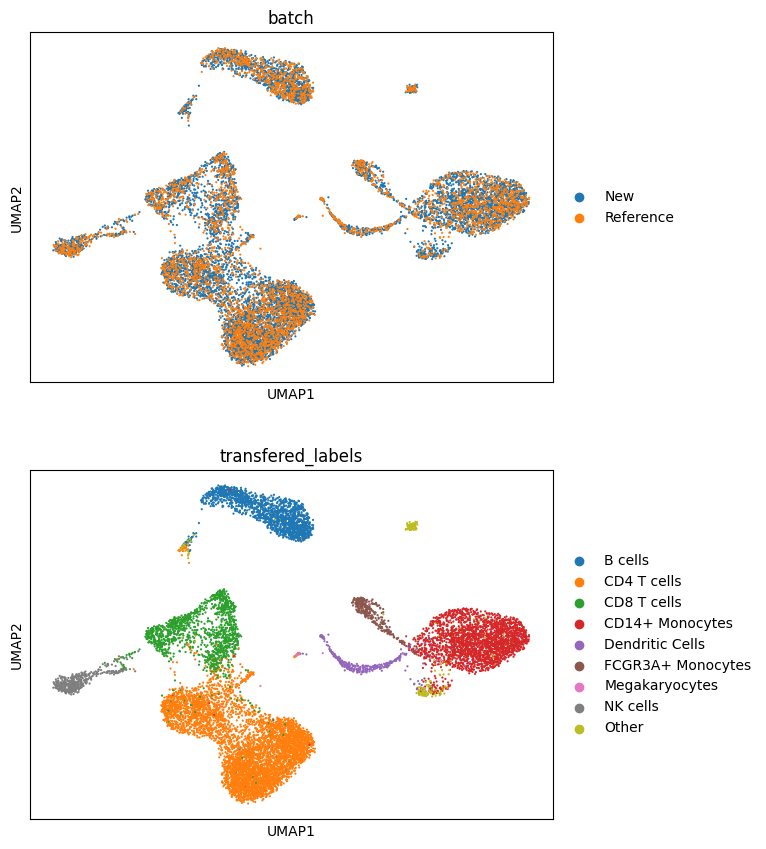

In [17]:
sc.pl.umap(adata, color=['batch', 'transfered_labels'],ncols=1)

Unaligned cells are those that cannot find counterparts in the reference data. These cells may represent cell types that are not present in the reference data.

# Save data

In [18]:
# adata.write(OUTPUT_PATH+'annotated_adata.h5ad')

In [19]:
# adata = ad.read_h5ad(OUTPUT_PATH+'annotated_adata.h5ad')